In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin) / num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_data = np.sin(self.x_data)
    
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        # Create random entry point for the batch
        rand_start = np.random.rand(batch_size, 1)
        #print('The random selected start is', rand_start)
        # Convert the random generated values on to time-series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        #print('The time series start is ', ts_start)
        # Convert the timeseries on the taxis
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        #print('The created time series is ', batch_ts)
        # Create Y data for time series in batches
        y_batch = np.sin(batch_ts)
        #print('The y_batch is', y_batch)
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [77]:
obj = TimeSeriesData(100, 0, 10)

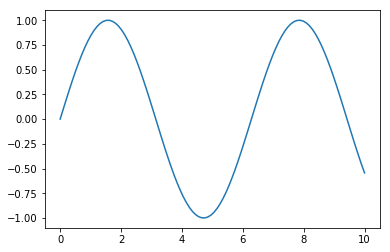

In [54]:
plt.plot(obj.x_data, obj.y_data)

The random selected start is [[ 0.5004921]]
The time series start is  [[ 4.00393678]]
The created time series is  [[ 4.00393678  4.10393678  4.20393678  4.30393678  4.40393678  4.50393678
   4.60393678  4.70393678  4.80393678  4.90393678  5.00393678  5.10393678
   5.20393678  5.30393678  5.40393678  5.50393678  5.60393678  5.70393678
   5.80393678  5.90393678  6.00393678]]
The y_batch is [[-0.75936988 -0.82053372 -0.87349906 -0.91773669 -0.9528046  -0.9783524
  -0.99412482 -0.99996428 -0.99581243 -0.98171074 -0.95780013 -0.9243195
  -0.88160337 -0.83007855 -0.77025986 -0.70274499 -0.62820852 -0.5473952
  -0.46111249 -0.3702225  -0.27563336]]


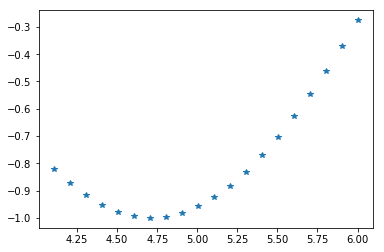

In [55]:
num_time_steps = 20
y1, y2, ts = obj.next_batch(1, num_time_steps, True)
plt.plot(ts.flatten()[1:], y2.flatten(), '*' )

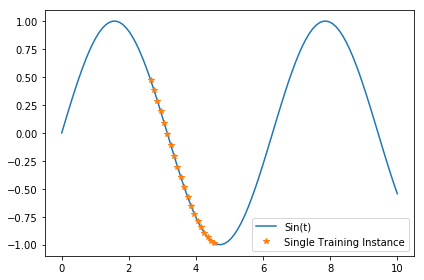

In [51]:
plt.plot(obj.x_data,obj.y_data,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

In [56]:
train_inst = np.linspace(5, 5 + obj.resolution * (num_time_steps + 1), num_time_steps + 1)

In [58]:
train_inst[:-1]

array([ 5.   ,  5.105,  5.21 ,  5.315,  5.42 ,  5.525,  5.63 ,  5.735,
        5.84 ,  5.945,  6.05 ,  6.155,  6.26 ,  6.365,  6.47 ,  6.575,
        6.68 ,  6.785,  6.89 ,  6.995])

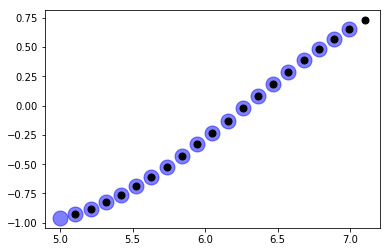

In [64]:
plt.plot(train_inst[:-1], obj.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], obj.ret_true(train_inst[1:]), "ko", markersize=7, label="target")

In [65]:
tf.reset_default_graph()

In [66]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_train_iterations = 2000
batch_size = 1

In [67]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [68]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

In [69]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [70]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [71]:
init = tf.global_variables_initializer()

In [72]:
saver = tf.train.Saver()

In [78]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        X_batch, y_batch = obj.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y:y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE", mse)
            
    saver.save(sess, "./rnn_time_series_model")

0 	MSE 0.598733
100 	MSE 0.154626
200 	MSE 0.0534313
300 	MSE 0.0630022
400 	MSE 0.0375069
500 	MSE 0.0267566
600 	MSE 0.00993186
700 	MSE 0.0249748
800 	MSE 0.0199825
900 	MSE 0.017777
1000 	MSE 0.015019
1100 	MSE 0.0264068
1200 	MSE 0.00344689
1300 	MSE 0.00922634
1400 	MSE 0.00171577
1500 	MSE 0.0124514
1600 	MSE 0.00867086
1700 	MSE 0.00584292
1800 	MSE 0.00555525
1900 	MSE 0.00216564


In [80]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


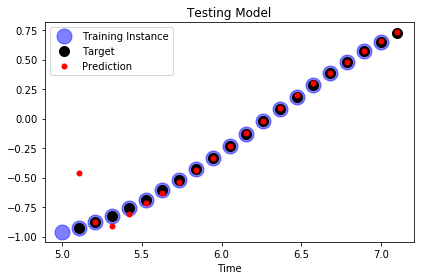

In [82]:
plt.title('Testing Model')
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='Training Instance')
plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', markersize=10, label='Target')
plt.plot(train_inst[1:], y_pred[0,:,0], 'r.', markersize=10, label='Prediction')
plt.xlabel("Time")
plt.legend()
plt.tight_layout()

In [90]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")
    
    training_instance = list(obj.y_data[:20])
    for iteration in range(len(obj.x_data) - num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


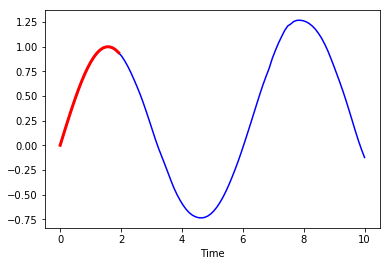

In [91]:
plt.plot(obj.x_data, training_instance, "b-")
plt.plot(obj.x_data[:num_time_steps], training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel('Time')